# Clustering the Countries by using Unsupervised Learning 
Objective:
To categorise the countries using socio-economic and health factors that determine the overall development of the country
Problem Statement:
HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
country_data=pd.read_csv('C:/Users/vinit.babar/Documents/Python Scripts/Country-data.csv')

# Data Quality checks

In [5]:
# data set is small.
# All features except country are numerical 
# none of the feature has null values. 
country_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

In [11]:
# we don't see any of the field has junk value
for c in country_data.columns:
    string_null = np.array([x in a[2:] for x in country_data[c]])
    print(c, country_data[c].isnull().sum(), string_null.sum()) 

country 0 0
child_mort 0 0
exports 0 0
health 0 0
imports 0 0
income 0 0
inflation 0 0
life_expec 0 0
total_fer 0 0
gdpp 0 0


# EDA and Data Understanding

In [12]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [ ]:
# Few of the observation from data - 
# Child mortality - 50 % of country child mortality is 19 ..which is below than mean, would mean data is right skwed

In [ ]:
# Let's look at probability distribution for each column...let's start with child mortality 

<AxesSubplot:xlabel='child_mort', ylabel='Density'>

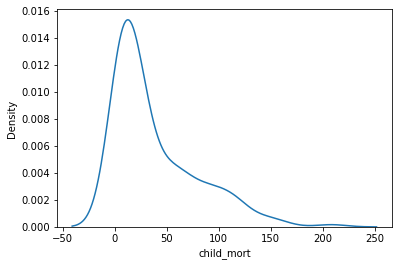

In [15]:
sns.kdeplot(data = country_data,x=country_data['child_mort'])

<AxesSubplot:xlabel='child_mort', ylabel='Count'>

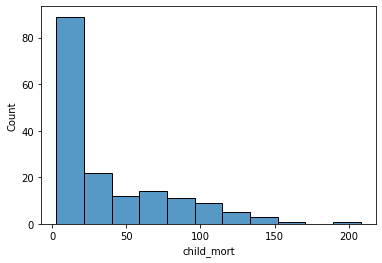

In [16]:
sns.histplot(data = country_data,x=country_data['child_mort'])

In [29]:
country_data_for_eda=country_data.loc[:,country_data.columns !='country']

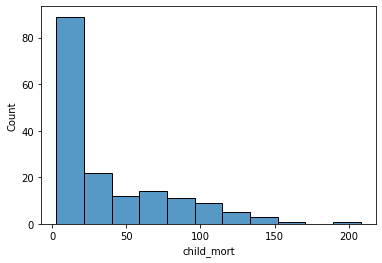

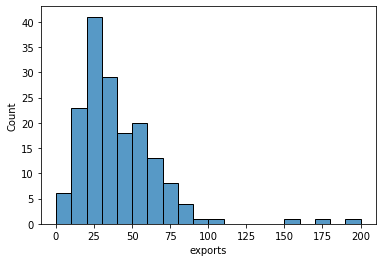

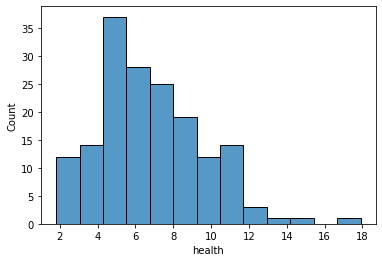

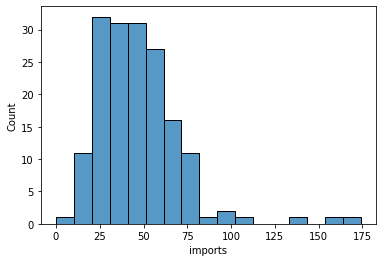

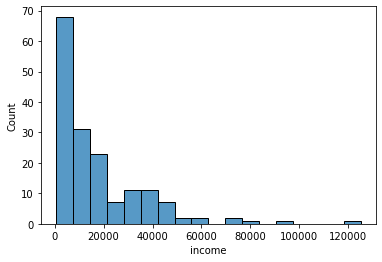

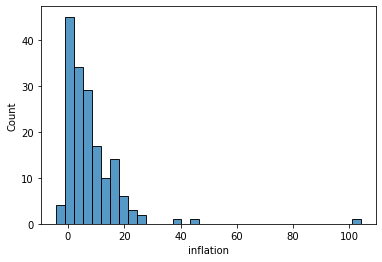

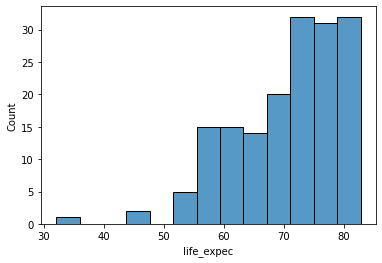

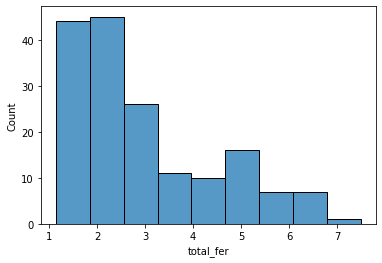

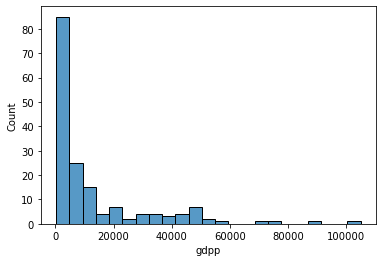

In [36]:
for c in country_data_for_eda.columns:
    plt.figure(c)
    sns.histplot(data = country_data_for_eda,x=country_data_for_eda[c])
    

Histograph :- Data distribution is not normalized for any of the feature. We also do see outlier however since our dataset is very small, we will not take out rows with outlier.

Pairwise Correlation :- let see if these features are correlated with each other

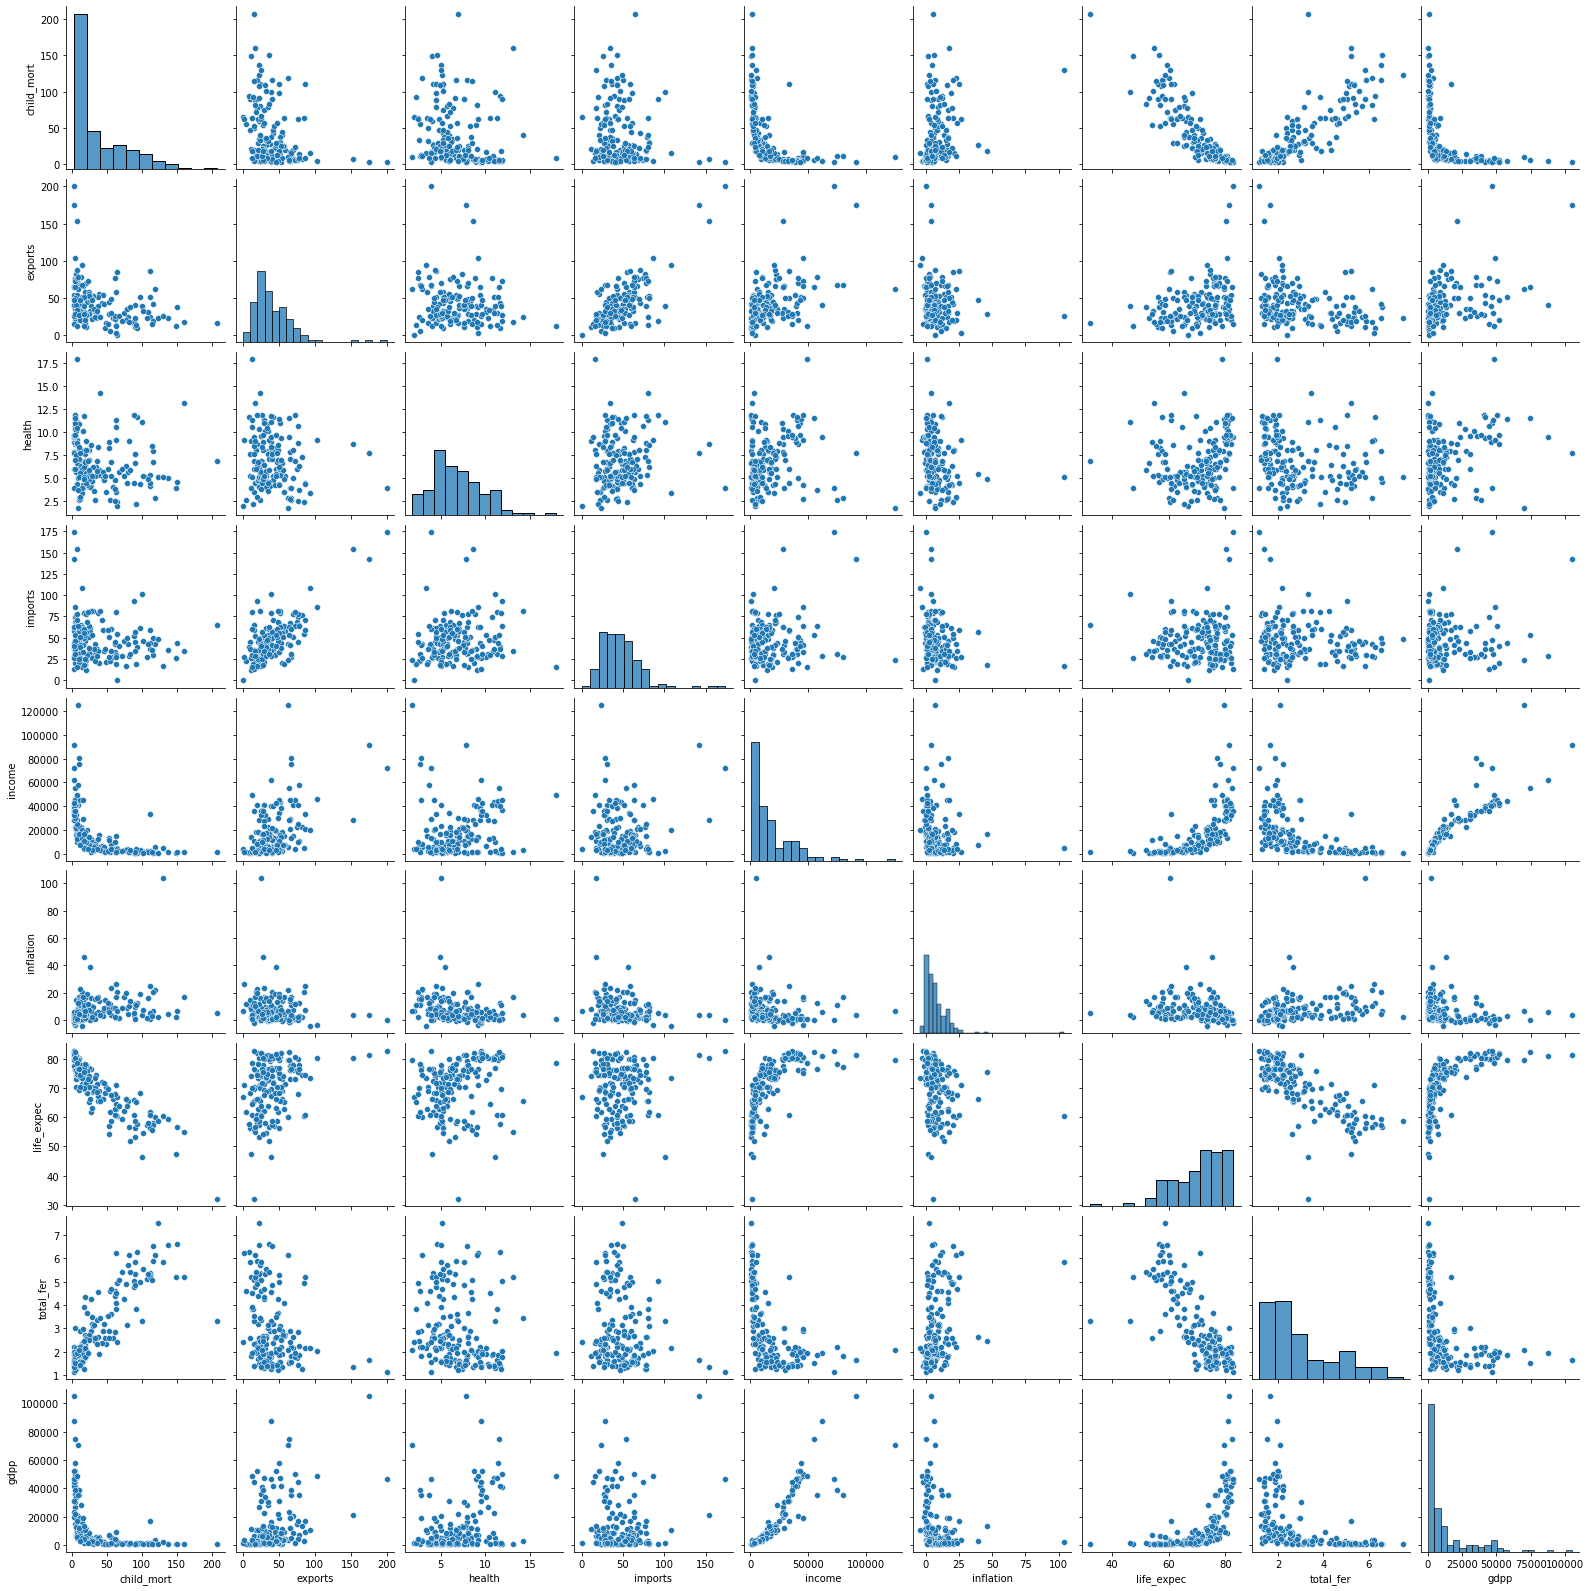

In [38]:
sns.pairplot(country_data)

Text(0.5, 1.0, 'Correlation Heatmap')

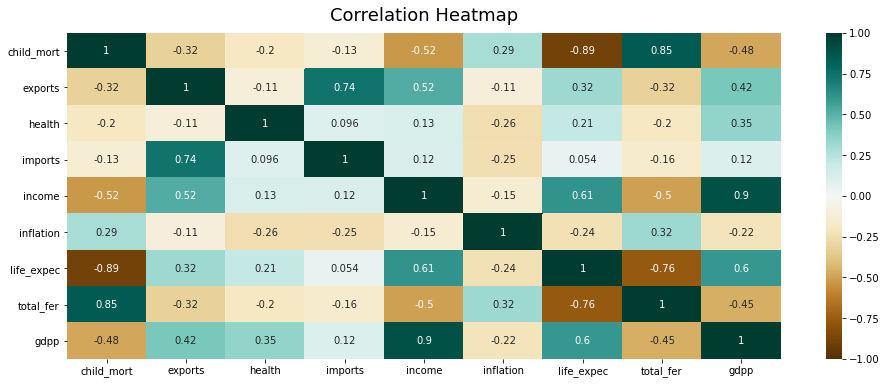

In [40]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(country_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
# few things standout is strong correlation between Person_age and cb_person_cred_hist_length
# We can take out one the column as they are correlated.

In [ ]:
# We do see strong correlation between few of features..like total fer and child mortality, life expectancy and child mortality
# export and import, income and GDP...
# while few features don;t have strong correlation
# this we should see distinctly in a cluster...
# clustering method do have a way to cluster by correlation...interesting to see how it turns out..

# Preprocessing of data

1) Since clustering uses the distance method, important to standardize the features..this is because different features are measured in a different unit of measuremenet and hence bigger values can unduly contribute to the output.
So importtant to standardize the features ( centralize and divide by standard deviation)

2) We will use standardscalar module to fit ( to get mean and sd) and transform to apply to data( scaling and standardizing data)

In [53]:
scaler = StandardScaler()

In [54]:
scaled_data=scaler.fit_transform(country_data_for_eda)

In [58]:
scaled_data.shape
type(scaled_data)

numpy.ndarray

In [60]:
country_data_scaled=pd.DataFrame(scaled_data,columns=country_data_for_eda.columns)

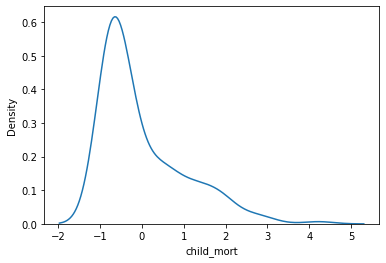

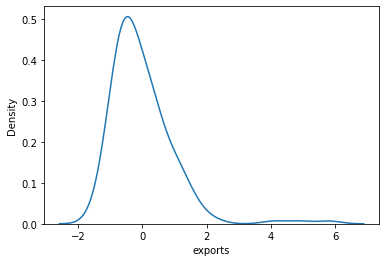

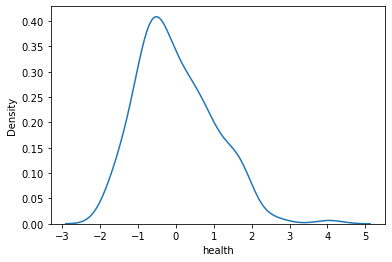

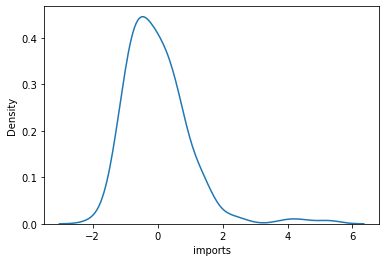

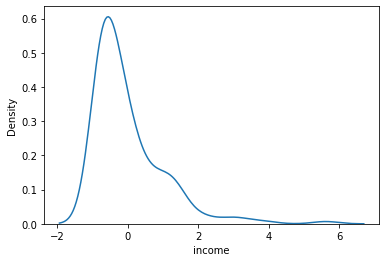

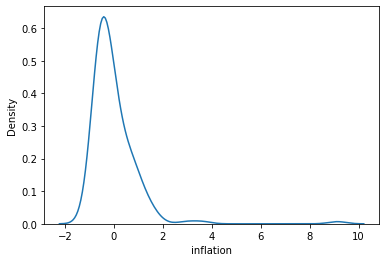

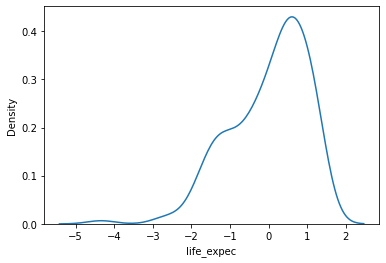

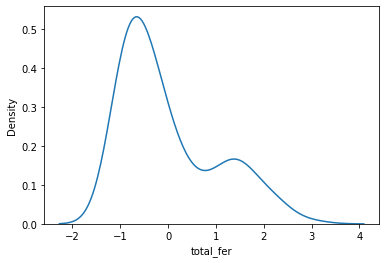

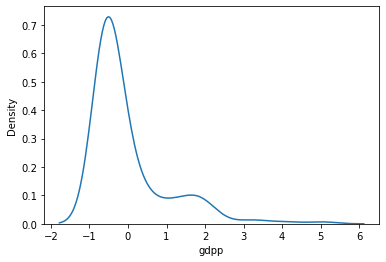

In [65]:
# this is for my learning- standardization doesn't affect the shape of distribution 
# it just get the distribution, centered around zero and points are sd =1 ( Z-score)
# for normalization, sklearn provides min-max scalar
# however in our use case, we should be good using standard scalar as idea is to make feature centered around it's mean value.

for c in country_data_scaled.columns:
    plt.figure(c)
    sns.kdeplot(data = country_data_scaled,x=country_data_scaled[c])
    

In [67]:
country_data_scaled.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-2.659217e-17,2.383323e-16,5.218713e-16,2.871954e-16,-7.512288e-17,3.988825e-18,3.616535e-16,3.124580e-16,2.127373e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00,-6.968005e-01
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-6.366596e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.544309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01,5.942100e-02
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00,5.036507e+00


# Kmean Clustering

In [ ]:
# Elbow method to determine the number of clusters
# We will use elbow method using Inertia 
# we see that decrease is inertia is not significant after 3 or 4 clusters
# So let's see one more metrics - Silhouette Coefficient to determine the number of clusters


C:\Users\vinit.babar\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


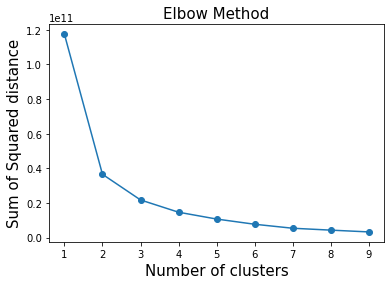

In [91]:
a=[]
K=range(1,10)
for i in K:
    kmean=KMeans(n_clusters=i)
    kmean.fit(country_data_for_eda)
    a.append(kmean.inertia_)
    
plt.plot(K,a,marker='o')
plt.title('Elbow Method',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Sum of Squared distance',fontsize=15)
plt.show()

In [131]:
kmean_3_clusters =KMeans(n_clusters=3,n_init=10, max_iter=3000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(scaled_data)

In [132]:
metrics.silhouette_score(scaled_data,kmean_3_clusters.labels_)

0.28329575683463126

In [122]:
kmean_4_clusters =KMeans(n_clusters=4,n_init=10, max_iter=3000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(scaled_data)

In [123]:
metrics.silhouette_score(scaled_data,kmean_4_clusters.labels_)

0.301375962376881

In [133]:
kmean_2_clusters =KMeans(n_clusters=2,n_init=10, max_iter=3000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(scaled_data)

In [134]:
metrics.silhouette_score(scaled_data,kmean_2_clusters.labels_)

0.28735668921406704

# Optimum number of clusters :- 4 

# As silhouette_score is more for 4 clusters compared to 3 clusters...we go with 4 clusters

#Attaching label to data

In [124]:
kmean_4_clusters.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 3, 1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [130]:
unique, counts = np.unique(kmean_4_clusters.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 47, 1: 87, 2: 30, 3: 3}

In [135]:
country_data['cluster_number']=kmean_4_clusters.labels_

In [136]:
country_data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_number
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0


In [ ]:
# let's understand the each of clusters to see if we can understand the natural grouping between countries

In [156]:
countries_Data_cluster_0=country_data[country_data['cluster_number']==0]

In [157]:
countries_Data_cluster_0.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_number
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.0
mean,92.961702,29.151277,6.388511,42.323404,3942.404255,12.019681,59.187234,5.008085,1922.382979,0.0
std,33.375229,18.160597,2.662015,17.732741,5641.790360,15.509958,6.443521,1.041382,2956.103925,0.0
min,36.900000,2.200000,2.200000,17.200000,609.000000,0.885000,32.100000,2.590000,231.000000,0.0
25%,63.800000,16.950000,4.520000,29.800000,1390.000000,4.010000,56.650000,4.535000,550.000000,0.0
50%,90.200000,23.800000,5.660000,40.300000,1870.000000,8.920000,59.500000,5.060000,897.000000,0.0
75%,111.000000,38.200000,8.105000,49.450000,3675.000000,16.600000,62.850000,5.635000,1470.000000,0.0
max,208.000000,85.800000,13.100000,101.000000,33700.000000,104.000000,71.100000,7.490000,17100.000000,0.0


In [150]:
# Let's compare this overall data
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_number
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,0.934132
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809,0.729232
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000,0.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,0.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,1.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,3.000000


In [ ]:
# we obviously see that for cluster =0, the mean and median income is much lower than overall mean and median income
# So try to analyze few metrices for each cluster
# let's take "income , "health" and "import" to see what value we see in each cluster for these features
# reason to select these 3 features is that they don't have strong correlation between them

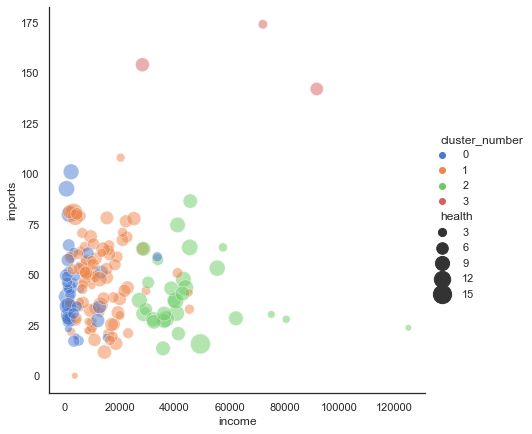

In [152]:
import seaborn as sns
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="income", y="imports", hue="cluster_number", size="health",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=country_data)

# Observations from above graph :- 
Cluster 0 :- Countries with less net income per person. Net income per person has high corrleatin with GDP. so these are countries with low GDP too
Cluster 1 :-  Countries with better income and likely GDP compared to countries in cluster 0
Cluster 2 :-  Countries with best income and best GDP 
cluster 3 :- Countries with best income, GDP but has very high import.

One more observation:-  irrespective of GDP or net income per person, import can be high or low.


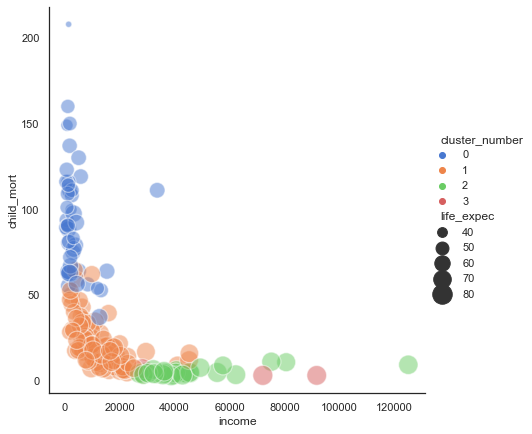

In [154]:
# let's use the variables/features which are highly correlated to each other
# those are income, life_expec child_mort
import seaborn as sns
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="income", y="child_mort", hue="cluster_number", size="life_expec",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=country_data)

# Observations :- 
Child mortality rate is higher for low net income country and hence more budget should be allocated to low income country to improve the health care in those countries.

In [158]:
#Curious on the countries in cluster 3
# in think that these are countries with higher import

country_data[country_data['cluster_number']==3]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_number
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,3
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,3
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,3


# Hierarchical Clustering

In [244]:
# Hierarchical Clustering
# let's use 4 clusters
hierarchical_model=AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='ward').fit(scaled_data)

In [245]:
hierarchical_model

AgglomerativeClustering(n_clusters=4)

In [246]:
hierarchical_model

AgglomerativeClustering(n_clusters=4)

In [247]:
metrics.silhouette_score(scaled_data,hierarchical_model.labels_)

0.24811891847692066

# Observation :- 
1) Hierarchical clustering offers better silhouette_score compared kmean clustering.
2) Let's assign the label to countries using hierachical clustering now.

In [248]:
# lets see how many countries goes in each cluster
unique, counts = np.unique(hierarchical_model.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 106, 1: 31, 2: 27, 3: 3}

In [249]:
# lets assign label to each row
country_data['Hierarchical_cluster_number']=hierarchical_model.labels_

In [250]:
country_data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_number,Hierarchical_cluster_number
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1,0
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1,0
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1,0
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0,0


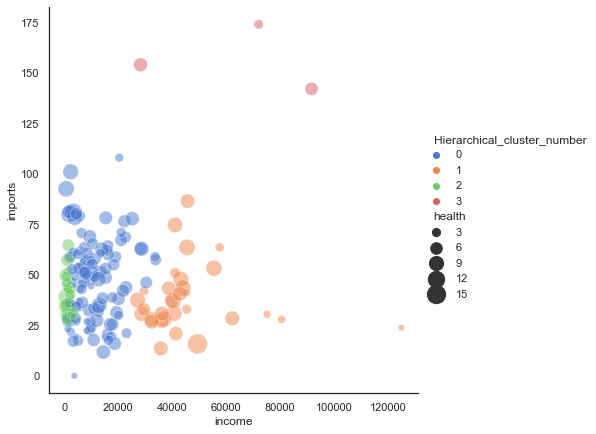

In [251]:
# Let's do the analysis now usin hierarchical cluster number, similar to that we did the cluster number obtained using kmean
import seaborn as sns
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="income", y="imports", hue="Hierarchical_cluster_number", size="health",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=country_data)

# Observation
1. Since the silhouette_score is less for hiearchical model is less than kmean, i think that we are not seeing clear distinction for countries based on income
2. However, overall clustering seems to be similar to that kmean cluster

In [ ]:
# More Technical exercise to see if we can use principle components as an input to cluster

In [257]:
# let provide scaled data to pca


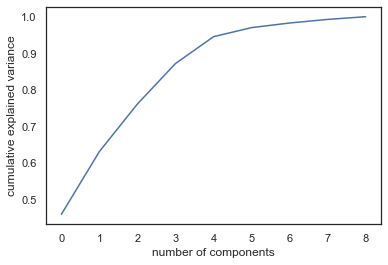

In [259]:
pca = PCA().fit(scaled_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Observations  
1. 4 components explain maximum variability in data. So let's consider 4 components for further analysis


In [270]:
pca = PCA(n_components=4).fit_transform(scaled_data)

In [273]:
pca.shape

(167, 4)

In [263]:
scaled_data.shape

(167, 9)

In [279]:
# let's use kmean clustering and use the principle components as input to it.
# so let's use same number of clusters that we got it before

In [281]:
kmean_4_clusters_pca =KMeans(n_clusters=4,n_init=10, max_iter=3000, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto').fit(pca)

In [282]:
kmean_4_clusters_pca.labels_

array([0, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 0,
       1, 3, 1, 0, 0, 1, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 1,
       3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3, 0, 0, 1, 3, 0, 3, 1, 1, 0, 0, 1,
       0, 1, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 1, 1, 0, 0, 3, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       3, 3, 0, 0, 3, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 1, 3, 1, 0, 3, 3, 1, 1, 0, 1, 3, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0])

In [283]:
unique, counts = np.unique(kmean_4_clusters_pca.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 47, 1: 87, 2: 3, 3: 30}

In [284]:
# lets assign label to each row
country_data['Kmean_PCA_cluster_number']=kmean_4_clusters_pca.labels_

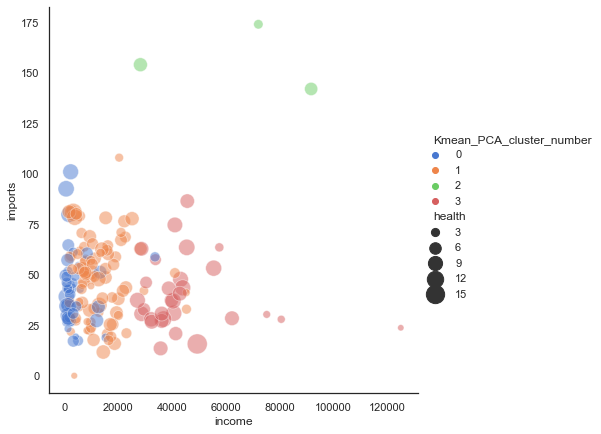

In [285]:
import seaborn as sns
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="income", y="imports", hue="Kmean_PCA_cluster_number", size="health",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=country_data)

In [ ]:
#Observation :- We do see the cluster created with scaled data as input vs PCA as input to kmean is almost similar